# Flood Adaptation: Minimal Model

This python script outlines a basic Agent-Based Model (ABM) developed using the Mesa framework, designed as a simplified representation of household adaptation to flood events in a social network context. The model serves as a template for understanding the fundamental mechanics of flood adapdtation with a given social network.

This directory is structured as follows:
 - A Mesa Agent class `Households` is defined in `agents.py`
 - A Mesa Agent class `Government` is defined in `agents.py` 
 - A Mesa Agent class `Government Implementation` is defined in `agents.py` 
 - A Mesa Agent class `Media` is defined in `agents.py` 
 - A Mesa Agent class `Insurance` is defined in `agents.py` 
 - A Mesa Model class `AdaptationModel` is defined in `model.py`
 - This notebook `demo.ipynb` provides a demonstration of the model and its visualization.

Each household agent in the model represents a household with attributes and behaviors that determine its response to flood events.

The current implementation includes a division of the floodmap into zones (currently just along the y axis). It also bases the floods on actual rain data of the past. It still takes a random sample but it could be seen as an actual environment.

This notebook will supply graphs and analysis to further understand the model

A few notes:

The amount of policies are hard coded to not be higher than 10.
The economy is very simple and is more there to provide a cap on the adaptation measures for households
The economy can be made inequal by setting the variable intorduce inequelity to True, this is inspried by the simple economy model, but even simpler.

_This notebook was tested on 2023-11-13 with Mesa version 2.1.4 on Python 3.12.0._

Model will run for 80 ticks where each tick is 1/4 of a year.

# Running the model and visualizing the model domain and social network over time

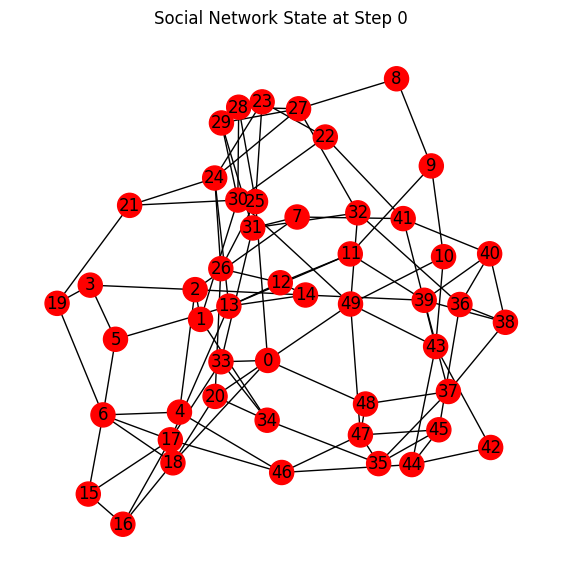

Running the model for 80 steps
Flood in zone (0, 263150.0)
Flood in zone (0, 263150.0)
Flood in zone (0, 263150.0)
Flood in zone (0, 263150.0)


<Figure size 1000x600 with 0 Axes>

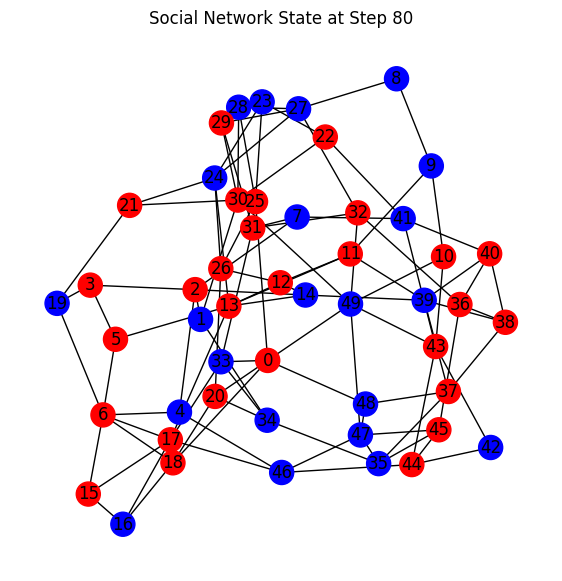

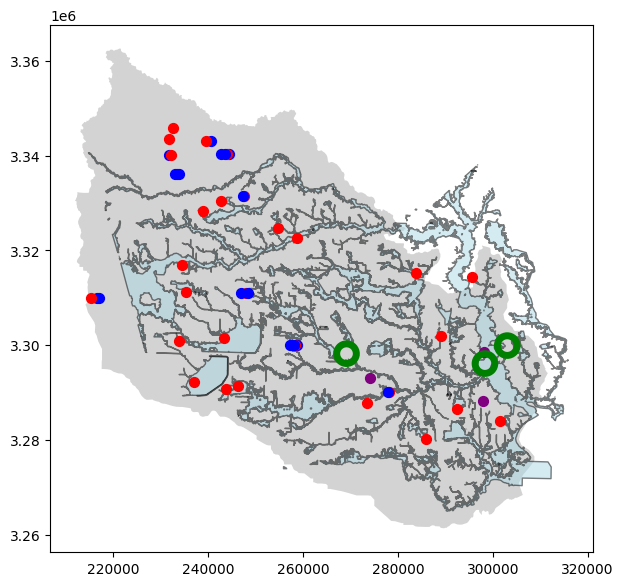

In [1]:
from model import AdaptationModel
import matplotlib.pyplot as plt
import networkx as nx
from functions import map_domain_gdf, floodplain_gdf

# Initialize the Adaptation Model with 50 household agents.
model = AdaptationModel(number_of_households=50, number_of_zones=2, flood_map_choice="harvey", network="watts_strogatz", adaptation_threshold=0.2, introduce_inequality=True, number_of_steps=80) # flood_map_choice can be "harvey", "100yr", or "500yr"
# Calculate positions of nodes for the network plot.
# The spring_layout function positions nodes using a force-directed algorithm,
# which helps visualize the structure of the social network.
pos = nx.spring_layout(model.G)

# Define a function to plot agents on the network.
# This function takes a matplotlib axes object and the model as inputs.
def plot_network(ax, model):
    # Clear the current axes.
    ax.clear()
    # Determine the color of each node (agent) based on their adaptation status
    household_agents = []
    goevernment_implemetaitons = [] # does not do much now
    for agent in model.schedule.agents:
        if agent.type == 'household':
            household_agents.append(agent)
        if agent.type == "implementation":
            goevernment_implemetaitons.append(agent)
        
    colors = ['blue' if agent.is_adapted else 'red' for agent in household_agents]

    # Draw the network with node colors and labels.
    nx.draw(model.G, pos, node_color=colors, with_labels=True, ax=ax)
    # Set the title of the plot with the current step number.
    ax.set_title(f"Social Network State at Step {model.schedule.steps}", fontsize=12)

# Plot the initial state of the social network.
fig, ax = plt.subplots(figsize=(7, 7))
plot_network(ax, model)
plt.show()

# Run the model for 20 steps and generate plots every 5 steps.
print(f"Running the model for {model.number_of_steps} steps")
for step in range(model.number_of_steps):
    model.step()

    # Every 5 steps, generate and display plots for both the spatial distribution and network.
    # Note the first step is step 0, so the plots will be generated at steps 4, 9, 14, and 19, which are the 5th, 10th, 15th, and 20th steps.
    if step  == model.number_of_steps-1:
        # Plot for the spatial map showing agent locations and adaptation status.
        plt.figure(figsize=(10, 6))
        #model.plot_model_domain_with_agents()
        # Plot for the social network showing connections and adaptation statuses.
        fig, ax = plt.subplots(figsize=(7, 7))
        plot_network(ax, model)
        plt.show()

# Plot the model domain
fig, ax = plt.subplots(figsize=(7, 7))
map_domain_gdf.plot(ax=ax, color='lightgrey')
#Plot the floodplain
floodplain_gdf.plot(ax=ax, color='lightblue', edgecolor='k', alpha=0.5)
for agent in model.schedule.agents:
    if agent.type == "household" and agent.is_adapted == False:
        #get position on the map
        ax.scatter(agent.location.x, agent.location.y, color='red', s=50)  # Bigger, hollow circle
    elif agent.type == 'household':
        if agent in model.adapted_because_government:
            ax.scatter(agent.location.x, agent.location.y, color='purple', s=50)  # Smaller, filled circle
        else:
            ax.scatter(agent.location.x, agent.location.y, color='blue', s=50)  # Smaller, filled circle
    elif agent.type == "implementation":
        if agent.policy == "Dijks":
            ax.scatter(agent.location.x, agent.location.y, facecolors = "none", linewidths=5, edgecolors='green', s=200) 
        elif agent.policy == "Water locks":
            ax.scatter(agent.location.x, agent.location.y, facecolors = "none", linewidths=5, edgecolors='yellow', s=300) 

    

<h1><b> Data Analysis </h1></b>

For the data analysis there aren 3 chapters:

<b> -Single model analysis </b>
    <p>here the economy, adaption, reasons for adaption, implementations, flood data and media coverage are visualised and analysed. Here the outcome can be different, in my experiance about 1/3 of the runs have enough rainfall for government action. These models are a bit more exiting on the analysis part</p>

<b> -Multi model runs </b>
    <p>here the model will ran 100 times to account for some of the randomness.</p>
    
<b> Final takeaways and conclusions </b>
    <p>Here some final remarks will be made</p>


In the cell below all the different types of <b>agent_data</b> data will be catagorised in their own pandas dataframe. We have chosen for the household, government and implementation data as the insurance and media do not carry a lot of usefull data.

In [2]:
agent_data = model.datacollector.get_agent_vars_dataframe()
household_data = agent_data
government_data = agent_data
implementation_data = agent_data

#take out anaything that is not government
for i, j in enumerate(agent_data.Type[5]):
    if j != "household":
        household_data = household_data.drop(i, level='AgentID') #drop media and government
    if j != 'government':
        government_data = government_data.drop(i, level='AgentID')
    if j != 'implementation':
        implementation_data = implementation_data.drop(i, level='AgentID')

household_data.tail()

Type  FloodDepthEstimated  FloodDamageEstimated  \
Step AgentID                                                              
79   47            household                  0.0                   0.0   
     48            household                  0.0                   0.0   
     49            household                  0.0                   0.0   
     53       implementation                  NaN                   NaN   
     54       implementation                  NaN                   NaN   

              FloodDepthActual  FloodDamageActual IsAdapted         Money  \
Step AgentID                                                                
79   47                  0.345           0.462489      True  19042.445504   
     48                  0.345           0.462489     False  59581.421721   
     49                  0.345           0.462489      True  94333.413020   
     53                    NaN                NaN      None           NaN   
     54                    NaN                NaN      None           NaN   

             IsInsured  FriendsCount  \
Step AgentID                           
79   47           True           4.0   
     48           True           2.0   
     49           True           4.0   
     53           None           NaN   
     54           None           NaN   

                                                   location  
Step AgentID                                                 
79   47       POINT (214665.02612147856 3321591.0575545146)  
     48       POINT (228089.92687678203 3347197.9180069272)  
     49        POINT (223827.6158114302 3353907.0041542347)  
     53       POINT (303949.97326259746 3269435.1409894847)  
     54        POINT (281583.0184056501 3303188.6148276487)

The cell below shows the first few agents and their data, so mostly initial data.

In [3]:
agent_data_insured = agent_data.loc[agent_data['IsInsured']==True]
agent_data_insured.head()

Type  FloodDepthEstimated  FloodDamageEstimated  \
Step AgentID                                                         
1    0        household             1.420288              0.709560   
     1        household             1.063954              0.659124   
     2        household             1.303139              0.694530   
     3        household             0.821220              0.613910   
     4        household             0.000000              0.000000   

              FloodDepthActual  FloodDamageActual IsAdapted         Money  \
Step AgentID                                                                
1    0                     0.0                0.0     False   7375.423551   
     1                     0.0                0.0     False   4866.180183   
     2                     0.0                0.0      True   6279.354357   
     3                     0.0                0.0     False   2517.811390   
     4                     0.0                0.0     False  11918.517440   

             IsInsured  FriendsCount  \
Step AgentID                           
1    0            True           3.0   
     1            True           3.0   
     2            True           4.0   
     3            True           5.0   
     4            True           3.0   

                                                   location  
Step AgentID                                                 
1    0          POINT (220942.23087675738 3342015.36695178)  
     1          POINT (286426.75396418944 3262299.30040561)  
     2         POINT (225098.6158114302 3353907.0041542347)  
     3          POINT (286899.1297945522 3301887.644790434)  
     4        POINT (253464.36701863632 3305526.0953776524)

In [4]:
import pandas as pd
import numpy as np

household_data_per_agent = {}

for i in range(model.number_of_households):
    household_data_per_agent[i] = []

loop = 0
for i in household_data.Money:
    if loop == (model.number_of_households-1):
        loop = 0
        
    household_data_per_agent[loop].append(i)
    loop += 1

household_data_per_agent_dataset = pd.DataFrame([household_data_per_agent])
household_data_per_agent_dataset = household_data_per_agent_dataset.transpose()
household_data_per_agent_dataset.columns = ['Money']
household_data_per_agent_dataset.index.name = 'Agents'
household_data_per_agent_dataset.head()

household_data_per_agent_dataset["Money"].max()

[9843.0,
 2517.811390320763,
 7337.3543565429645,
 6159.180183092137,
 8705.423550699106,
 6205.91501807552,
 3367.189475186591,
 11527.528842613357,
 11078.065282830432,
 10354.466801268965,
 14218.570212336394,
 17503.26102082596,
 3837.564590335617,
 20557.980626230175,
 5238.352136347574,
 10732.177836394829,
 15445.66960542303,
 20229.74156115654,
 3982.023094958854,
 12490.877072831472,
 10478.416608517588,
 10393.997665099421,
 9746.339425057777,
 26301.698567621937,
 10399.41307191594,
 36957.669909691314,
 41067.58582729227,
 10506.16272382058,
 14292.572584799378,
 14970.988564607407,
 19193.837320743052,
 36573.4397183512,
 26058.460635513977,
 27546.171140309445,
 25157.136047301952,
 11197.16644571363,
 7875.445974554952,
 46864.951774610185,
 nan,
 25484.801481417402,
 29520.40245802806,
 11184.797807304214,
 22121.567811126206,
 33983.941922929895,
 8148.72992644057,
 19279.315011676666,
 28968.92401190563,
 29901.799806973875,
 25934.885109975294,
 28374.45370713622,
 4

In [5]:
government_data.head()

,,Type,FloodDepthEstimated,FloodDamageEstimated,FloodDepthActual,FloodDamageActual,IsAdapted,Money,IsInsured,FriendsCount,location
Step,AgentID,,,,,,,,,,
0,51,government,NaN,NaN,NaN,NaN,None,3000000.0,None,NaN,None
1,51,government,NaN,NaN,NaN,NaN,None,2974318.0,None,NaN,None
2,51,government,NaN,NaN,NaN,NaN,None,2952066.0,None,NaN,None
3,51,government,NaN,NaN,NaN,NaN,None,2922839.0,None,NaN,None
4,51,government,NaN,NaN,NaN,NaN,None,2888214.0,None,NaN,None


In [6]:
implementation_data.tail()

Type  FloodDepthEstimated  FloodDamageEstimated  \
Step AgentID                                                              
77   54       implementation                  NaN                   NaN   
78   53       implementation                  NaN                   NaN   
     54       implementation                  NaN                   NaN   
79   53       implementation                  NaN                   NaN   
     54       implementation                  NaN                   NaN   

              FloodDepthActual  FloodDamageActual IsAdapted  Money IsInsured  \
Step AgentID                                                                   
77   54                    NaN                NaN      None    NaN      None   
78   53                    NaN                NaN      None    NaN      None   
     54                    NaN                NaN      None    NaN      None   
79   53                    NaN                NaN      None    NaN      None   
     54                    NaN                NaN      None    NaN      None   

              FriendsCount                                       location  
Step AgentID                                                               
77   54                NaN   POINT (281583.0184056501 3303188.6148276487)  
78   53                NaN  POINT (303949.97326259746 3269435.1409894847)  
     54                NaN   POINT (281583.0184056501 3303188.6148276487)  
79   53                NaN  POINT (303949.97326259746 3269435.1409894847)  
     54                NaN   POINT (281583.0184056501 3303188.6148276487)

In [7]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,total_adapted_households,media_coverage,number_of_floods,current_policy,AdaptedByGovernmentImplementation
0,0,0,0,No policy,"[<agents.Households object at 0x7fa3205901c0>,..."
1,7,0,0,No policy,"[<agents.Households object at 0x7fa3205901c0>,..."
2,7,0,0,No policy,"[<agents.Households object at 0x7fa3205901c0>,..."
3,7,0,0,No policy,"[<agents.Households object at 0x7fa3205901c0>,..."
4,7,0,0,No policy,"[<agents.Households object at 0x7fa3205901c0>,..."
...,...,...,...,...,...
75,35,2,4,Dijks,"[<agents.Households object at 0x7fa3205901c0>,..."
76,35,2,4,Dijks,"[<agents.Households object at 0x7fa3205901c0>,..."
77,35,2,4,Dijks,"[<agents.Households object at 0x7fa3205901c0>,..."
78,35,2,4,Dijks,"[<agents.Households object at 0x7fa3205901c0>,..."


In [8]:
agents = model_data["AdaptedByGovernmentImplementation"]
agents_adapted_by_government = []

for i in agents:
    if i != None and len(i) > 0:
        agents_adapted_by_government = i

print(agents_adapted_by_government)

print(f"Amount of agents adapted by the government measures {len(agents_adapted_by_government)}")

[<agents.Households object at 0x7fa3205901c0>, <agents.Households object at 0x7fa3233ae4a0>, <agents.Households object at 0x7fa3233afdf0>, <agents.Households object at 0x7fa3233ad990>]
Amount of agents adapted by the government measures 4


<Axes: title={'center': 'Money of each household'}, xlabel='Model tick', ylabel='money(euro)'>

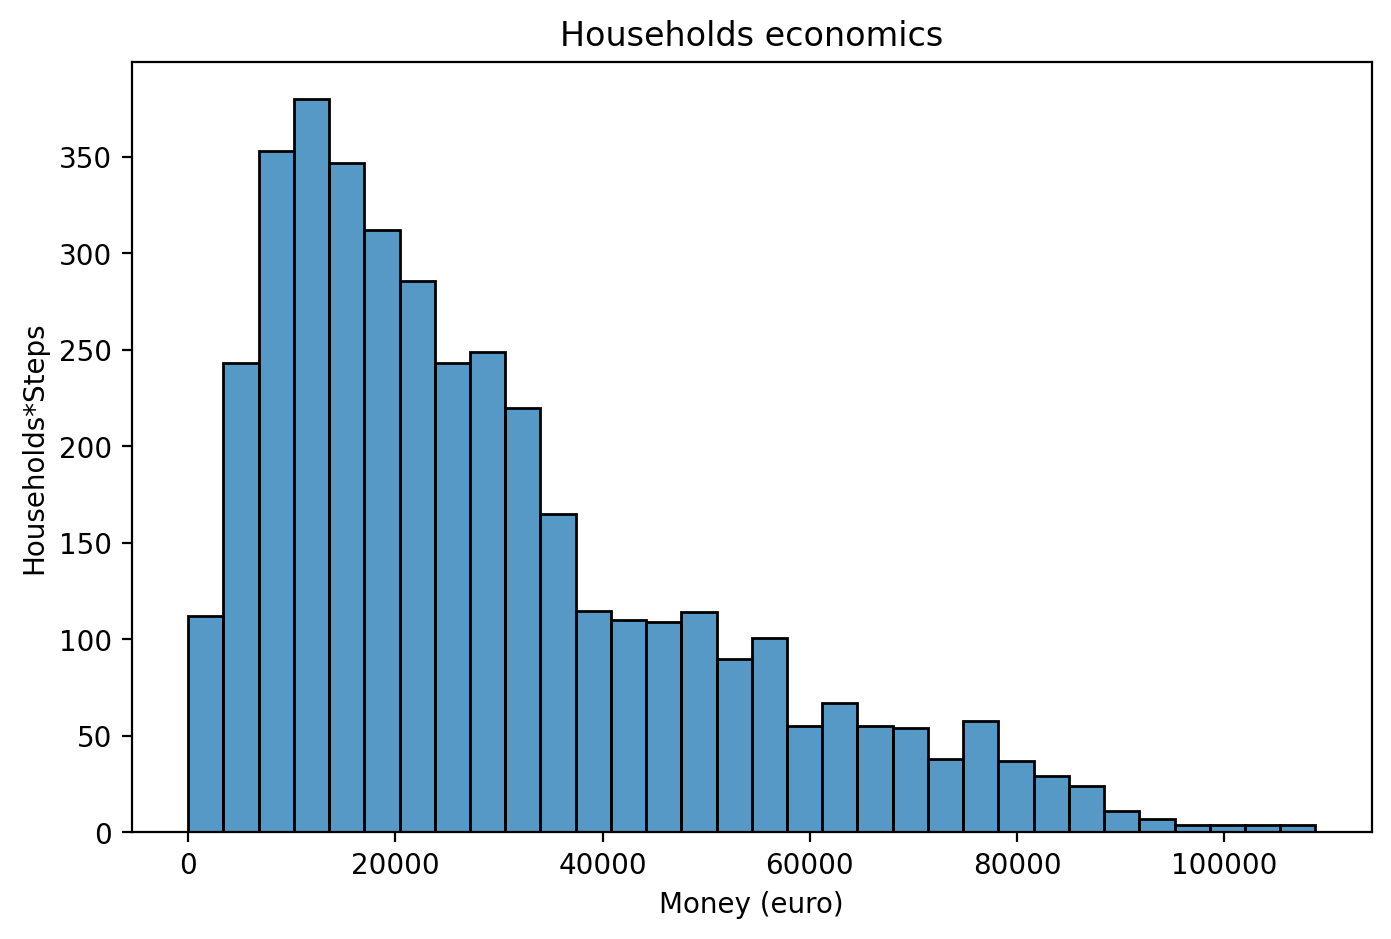

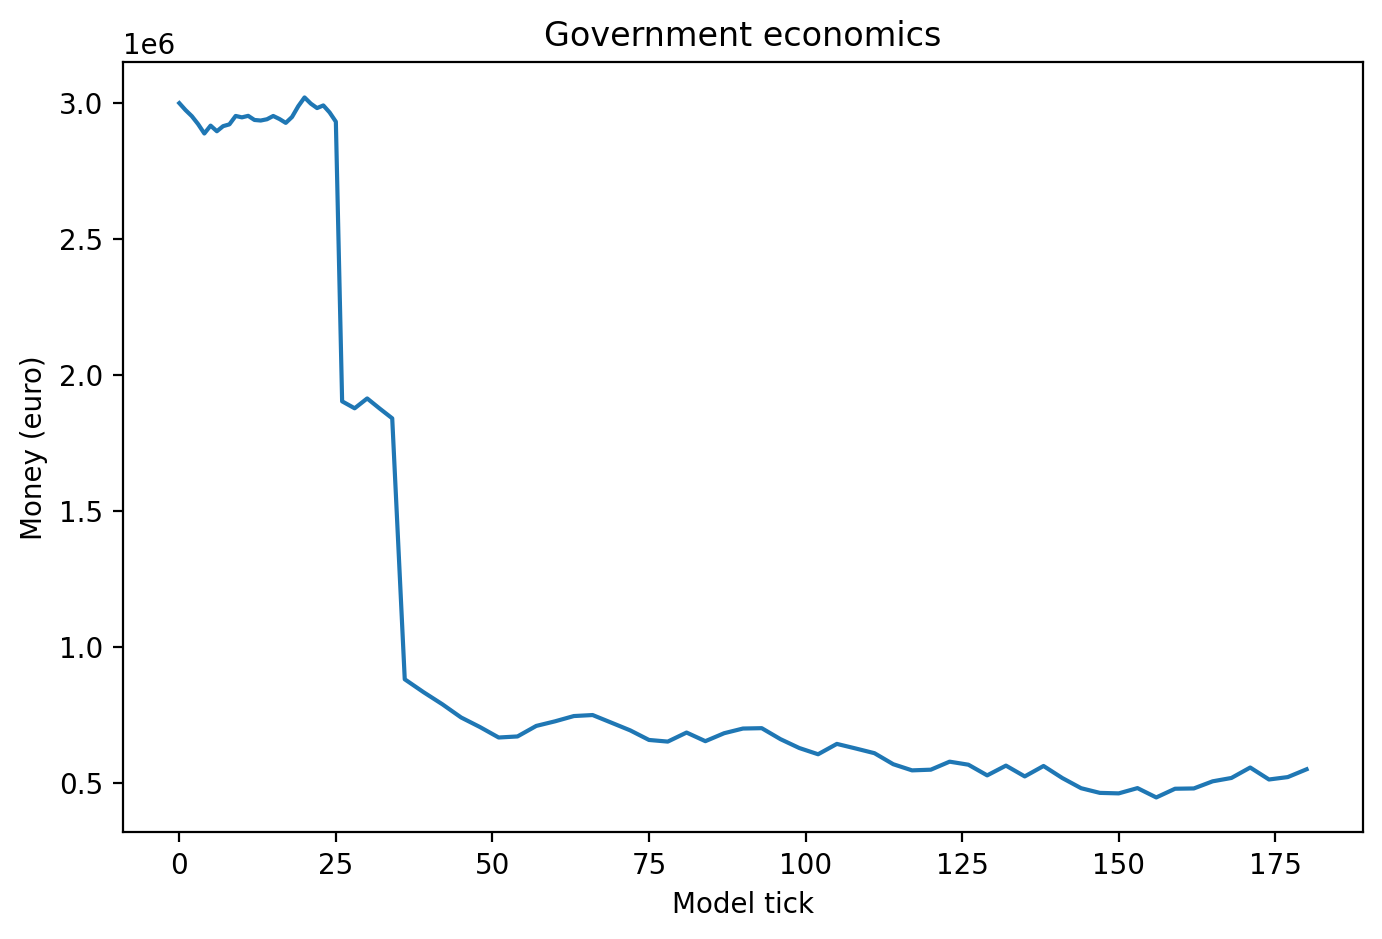

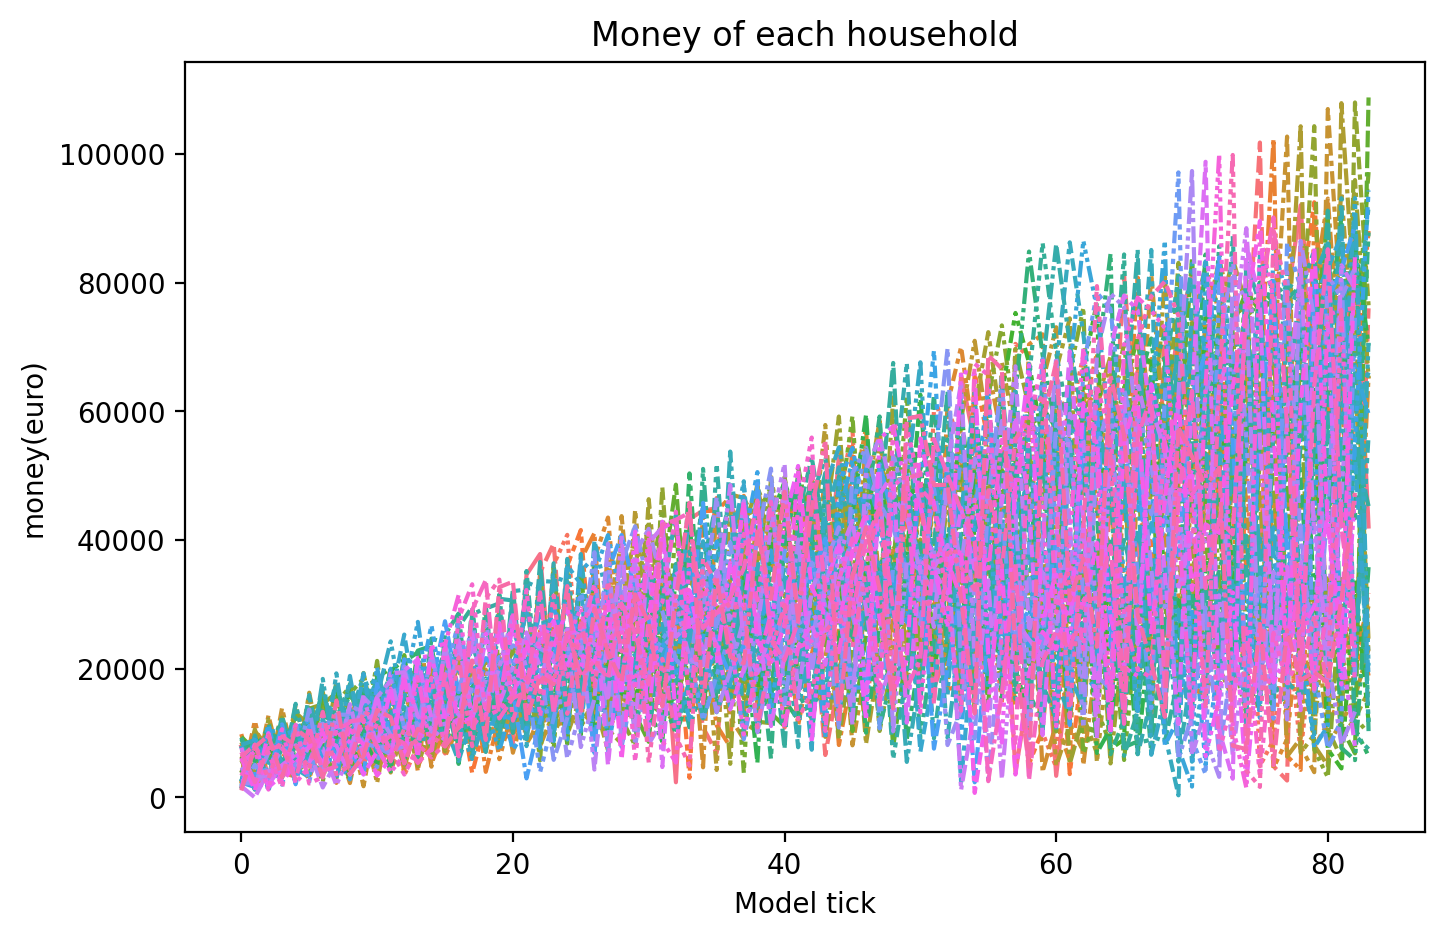

In [9]:
import seaborn as sns

#You will see that agents adapt at step 5 most because than the flood happend and only than the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Households economics")
ax.set_xlabel("Money (euro)")
ax.set_ylabel("Households*Steps")
sns.histplot(data = household_data.Money )

#You will see that agents adapt at step 5 most because than the flood happend and only than the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Government economics")
ax.set_xlabel("Model tick")
ax.set_ylabel("Money (euro)")
sns.lineplot(data = government_data.Money.to_list() )

#You will see that agents adapt at step 5 most because than the flood happend and only than the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Money of each household")
ax.set_xlabel("Model tick")
ax.set_ylabel("money(euro)")
sns.lineplot(data = household_data_per_agent, legend=None)

<Axes: title={'center': 'Policy changes over time'}, xlabel='Model tick', ylabel='Policy'>

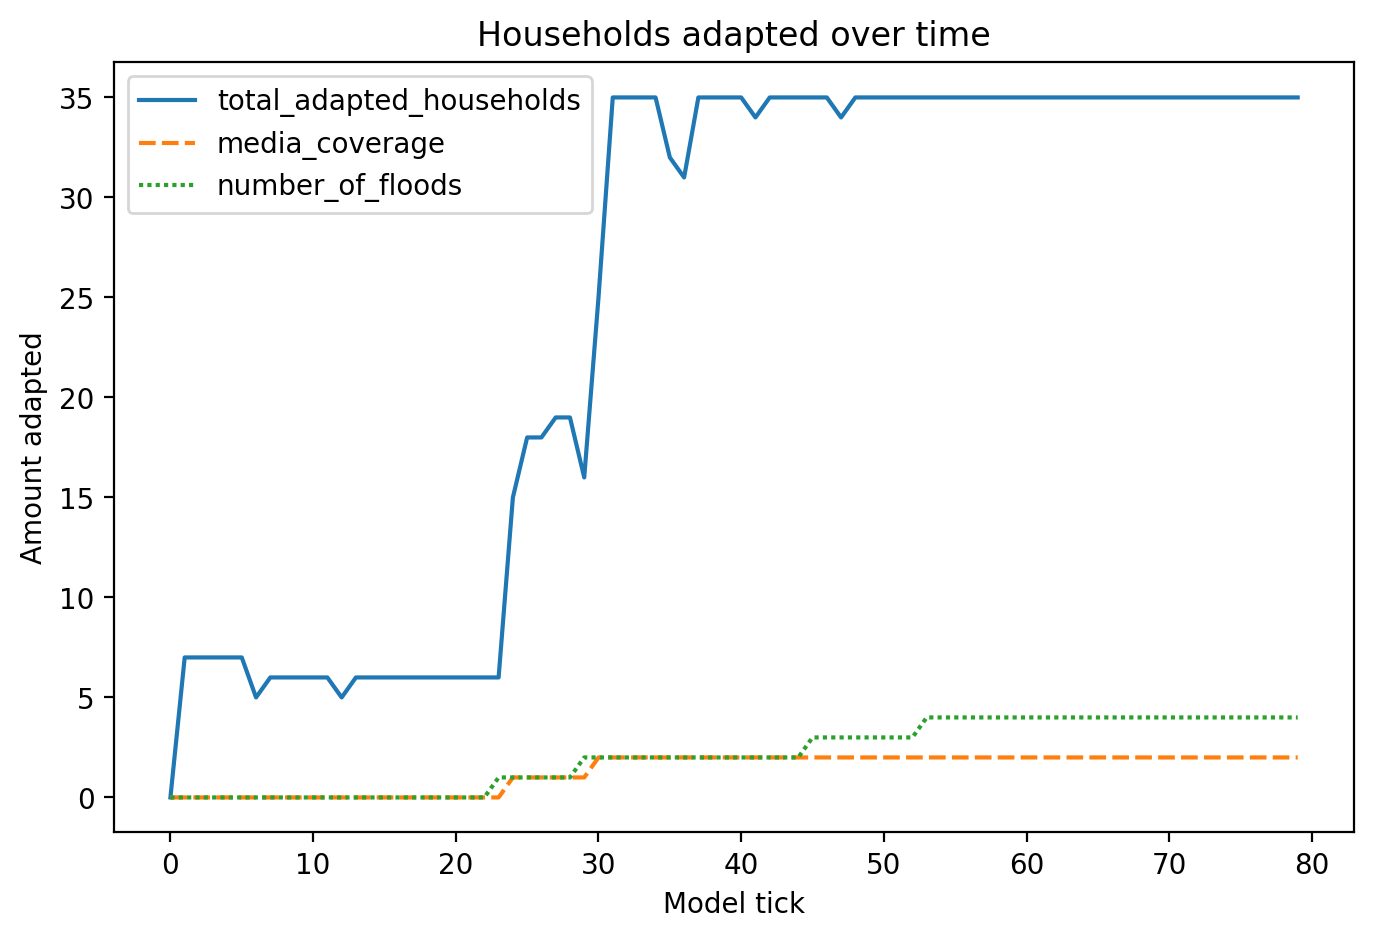

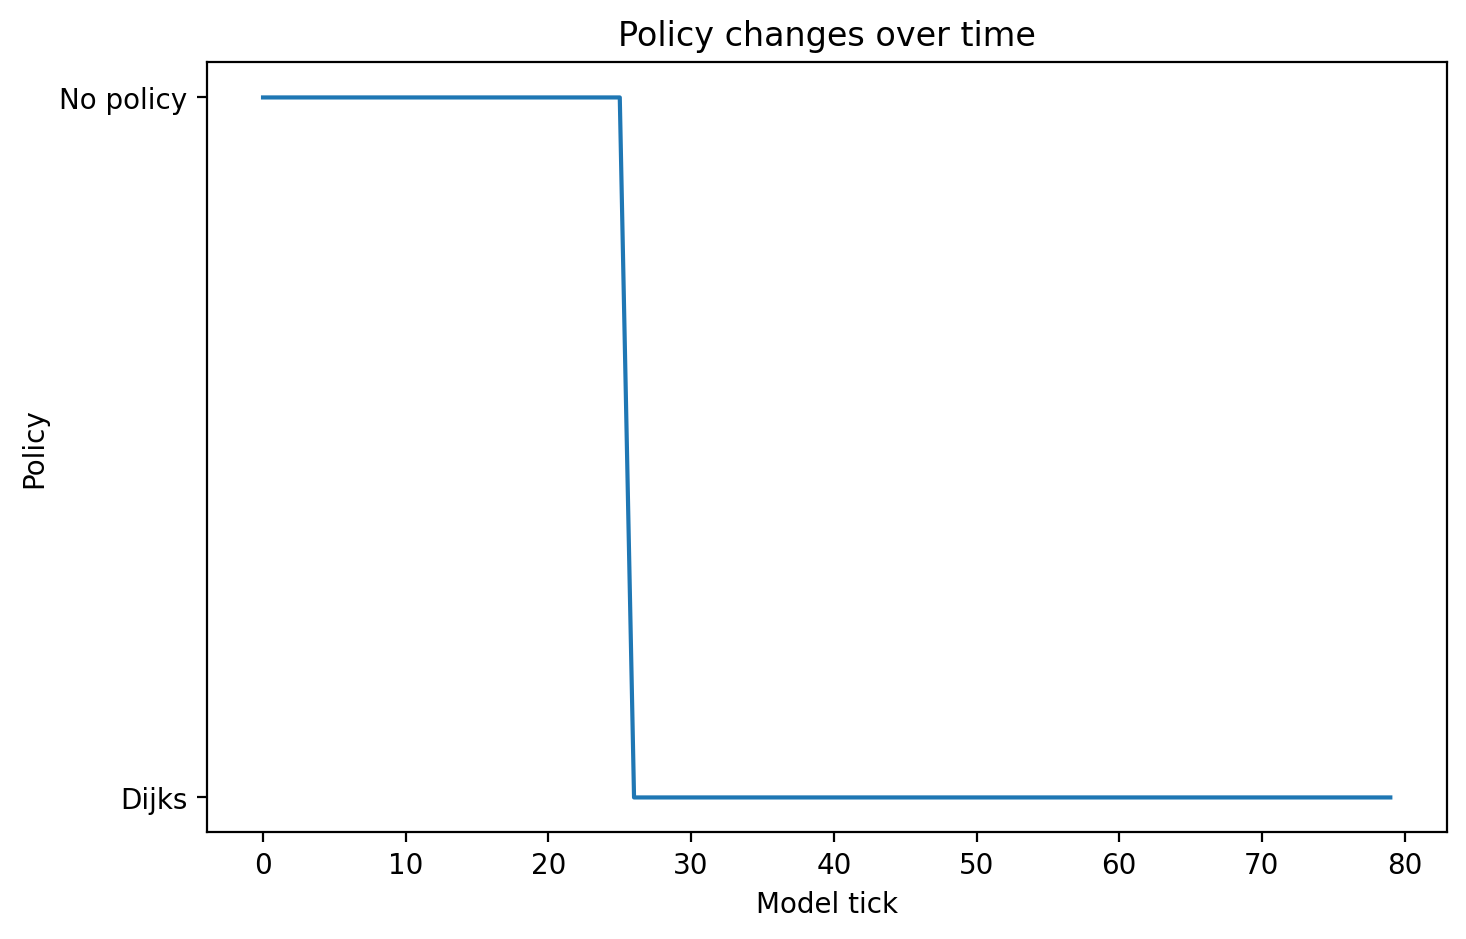

In [10]:
import seaborn as sns

#You will see that agents adapt at step 5 most because than the flood happend and only than the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Households adapted over time")
ax.set_xlabel("Model tick")
ax.set_ylabel("Amount adapted")
sns.lineplot(data = model_data )

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Policy changes over time")
ax.set_xlabel("Model tick")
ax.set_ylabel("Policy")
sns.lineplot(data = model_data.current_policy )
#sns.histplot(data = model_data.current_policy)

In [11]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
from functions import map_domain_gdf, floodplain_gdf

In [19]:
model = AdaptationModel(number_of_households=50, flood_map_choice="harvey", network="watts_strogatz", adaptation_threshold=0.2) #reset the model

In [21]:
fig, ax = plt.subplots()

# Adjust layout to make room for annotations
fig.subplots_adjust(bottom=0.2)

# Function to plot the grid at each step
def plot_grid(model):
    ax.clear()
    
    # Plot the model domain
    map_domain_gdf.plot(ax=ax, color='lightgrey')
    #Plot the floodplain
    floodplain_gdf.plot(ax=ax, color='lightblue', edgecolor='k', alpha=0.5)

    for agent in model.schedule.agents:
        if agent.type == "household" and agent.is_adapted == False:
            #get position on the map
            ax.scatter(agent.location.x, agent.location.y, color='red', s=50)  # Bigger, hollow circle
        elif agent.type == 'household':
            if agent in model.adapted_because_government:
                ax.scatter(agent.location.x, agent.location.y, color='purple', s=50)  # Smaller, filled circle
            else:
                ax.scatter(agent.location.x, agent.location.y, color='blue', s=50)  # Smaller, filled circle
        elif agent.type == "implementation":
            if agent.policy == "Dijks":
                ax.scatter(agent.location.x, agent.location.y, facecolors = "none", linewidths=5, edgecolors='green', s=200) 
            elif agent.policy == "Water locks":
                ax.scatter(agent.location.x, agent.location.y, facecolors = "none", linewidths=5, edgecolors='yellow', s=300) 
        # Labels and title
        
    plt.title(f'Model Domain with Agents at Step {model.schedule.steps}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

# Update function for the animation
def update(frame):
    plot_grid(model)
    model.step()
    

# Create the animation
anim = FuncAnimation(fig, update, frames=model.number_of_steps-2, repeat=False, interval=200)

# Show the animation
HTML(anim.to_jshtml())

IndexError: list index out of range